In [35]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

In [128]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

In [36]:
df=pd.read_csv('TRAIN.csv')
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [38]:
df.describe()

,Store_id,Holiday,#Order,Sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


<AxesSubplot:xlabel='Sales', ylabel='Density'>

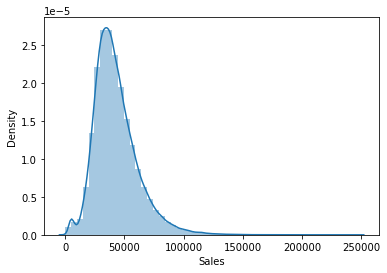

In [157]:
sns.distplot(df['Sales'])


<AxesSubplot:xlabel='#Order', ylabel='Density'>

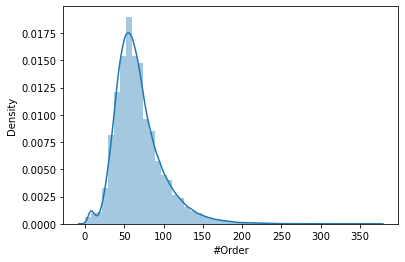

In [158]:
sns.distplot(df['#Order'])

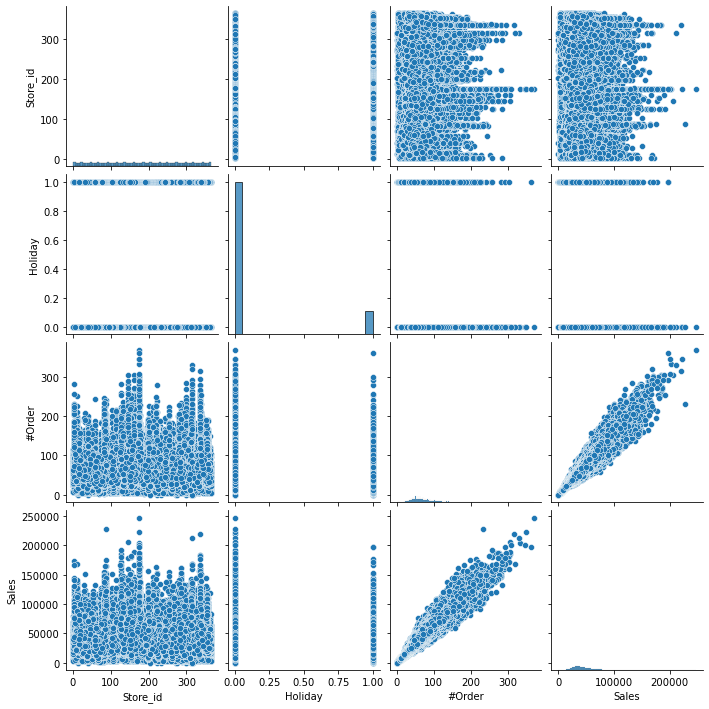

In [39]:
sns.pairplot(df)

<AxesSubplot:>

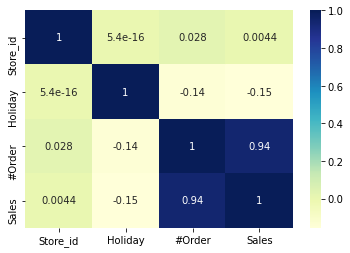

In [43]:
sns.heatmap(df.corr(),annot=True,cmap='YlGnBu')

Order and Sales has a very high correlation. We will first predict orders, then we predict sales from it

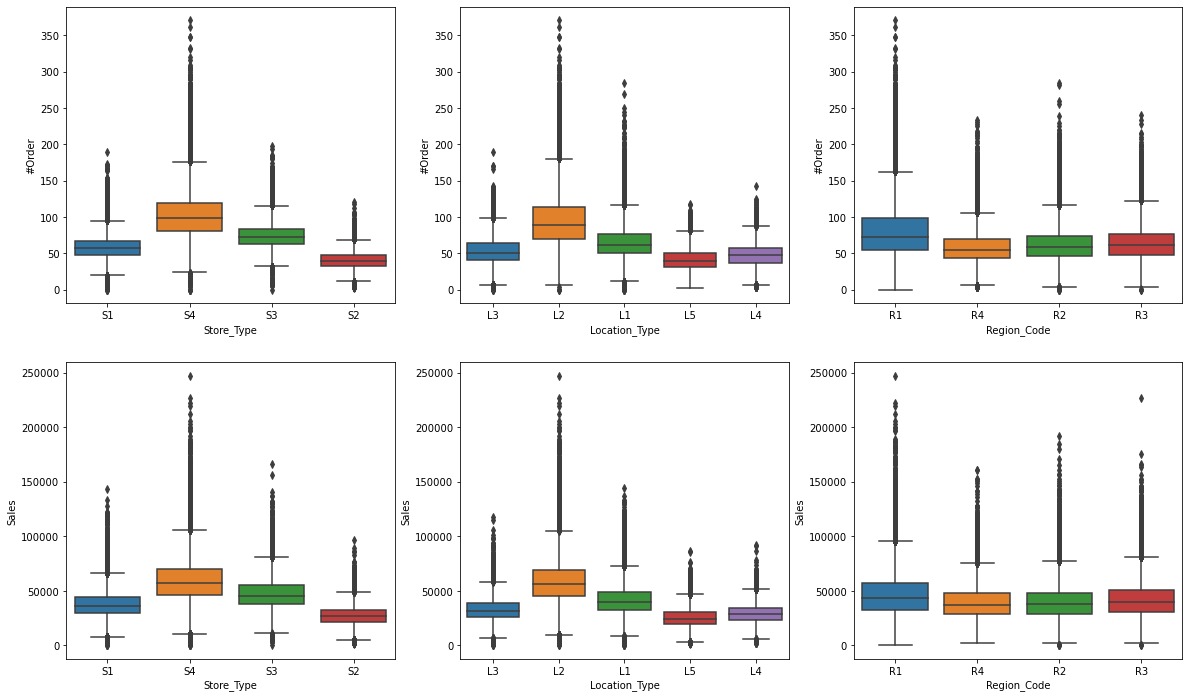

In [45]:
plt.figure(figsize=(20, 12))


plt.subplot(2,3,1)
sns.boxplot(x = 'Store_Type', y = '#Order', data = df)

plt.subplot(2,3,2)
sns.boxplot(x = 'Location_Type', y = '#Order', data = df)

plt.subplot(2,3,3)
sns.boxplot(x = 'Region_Code', y = '#Order', data = df)

plt.subplot(2,3,4)
sns.boxplot(x = 'Store_Type', y = 'Sales', data = df)

plt.subplot(2,3,5)
sns.boxplot(x = 'Location_Type', y = 'Sales', data = df)

plt.subplot(2,3,6)
sns.boxplot(x = 'Region_Code', y = 'Sales', data = df)

plt.show()

We cant consider sales and orders as outliers as its continuous data abve the upper hinge

In [48]:
df[df['Store_Type']=='S4']

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
9,T1000010,254,S4,L1,R1,2018-01-01,1,Yes,87,62572.80
10,T1000011,245,S4,L1,R2,2018-01-01,1,Yes,36,27468.21
11,T1000012,11,S4,L2,R1,2018-01-01,1,Yes,69,57590.40
12,T1000013,243,S4,L2,R2,2018-01-01,1,Yes,69,45563.25
...,...,...,...,...,...,...,...,...,...,...
188325,T1188326,338,S4,L2,R1,2019-05-31,1,No,101,63774.00
188330,T1188331,147,S4,L2,R4,2019-05-31,1,No,84,48026.88
188332,T1188333,150,S4,L2,R1,2019-05-31,1,Yes,137,86994.18
188333,T1188334,339,S4,L2,R1,2019-05-31,1,No,85,50018.34


# Preparing Data for modelling

In [49]:
df['Date']=pd.to_datetime(df['Date'])

In [50]:
df['Weekend']=np.where(  ((df['Date']).dt.dayofweek) < 5,0,1)

In [51]:
StoreType=pd.get_dummies(df['Store_Type'],drop_first=True)
StoreType.head()

,S2,S3,S4
0,0,0,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0


In [52]:
LocType=pd.get_dummies(df['Location_Type'],drop_first=True)
LocType.head()

,L2,L3,L4,L5
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0


In [53]:
RegCode=pd.get_dummies(df['Region_Code'],drop_first=True)
RegCode.head()

,R2,R3,R4
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,1


In [54]:
df=pd.concat([df,StoreType,LocType,RegCode],axis=1)

In [55]:
df['Discount']=df[['Discount']].apply(lambda x: x.map({'Yes':1,'No':0}))

In [60]:
df.drop(['Store_Type','Location_Type','Region_Code'],axis=1,inplace=True)

In [61]:
df.head()

,ID,Store_id,Date,Holiday,Discount,#Order,Sales,Weekend,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4
0,T1000001,1,2018-01-01,1,1,9,7011.84,0,0,0,0,0,1,0,0,0,0,0
1,T1000002,253,2018-01-01,1,1,60,51789.12,0,0,0,1,1,0,0,0,0,0,0
2,T1000003,252,2018-01-01,1,1,42,36868.20,0,0,1,0,1,0,0,0,0,0,0
3,T1000004,251,2018-01-01,1,1,23,19715.16,0,1,0,0,0,1,0,0,0,0,0
4,T1000005,250,2018-01-01,1,1,62,45614.52,0,1,0,0,0,1,0,0,0,0,1


In [75]:
df.drop(['Store_id'],axis=1,inplace=True)

In [80]:
df.drop(['ID'],axis=1,inplace=True)

### Split and Scale Data

In [94]:
df_train,df_test=train_test_split(df,train_size=0.7,random_state=100)

In [82]:
df2=df  ## Keeping copy so that we dont mistakenly write on df and all data is lost

In [95]:
scaler=MinMaxScaler()

var_list=['#Order','Sales']
df_train[var_list]=scaler.fit_transform(df_train[var_list])

In [84]:
df_train.head()

,Holiday,Discount,#Order,Sales,Weekend,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4
22964,0,1,0.180593,0.190741,1,0,0,0,0,0,0,0,0,0,1
81316,0,1,0.194070,0.209465,1,0,0,0,0,0,0,0,0,0,1
167174,0,1,0.140162,0.112166,0,0,0,0,0,0,1,0,0,0,0
162541,0,0,0.056604,0.045094,0,0,0,0,0,1,0,0,1,0,0
69960,0,0,0.312668,0.259462,0,0,0,1,1,0,0,0,0,0,0


In [85]:
df_train.describe()

,Holiday,Discount,#Order,Sales,Weekend,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4
count,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000,131838.000000
mean,0.131320,0.447026,0.183899,0.173072,0.284235,0.154053,0.131214,0.244103,0.257172,0.159878,0.057237,0.073818,0.289067,0.234818,0.136994
std,0.337752,0.497188,0.082097,0.074547,0.451051,0.361001,0.337636,0.429555,0.437076,0.366494,0.232296,0.261475,0.453331,0.423887,0.343842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.129380,0.123160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.169811,0.160379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.221024,0.210008,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

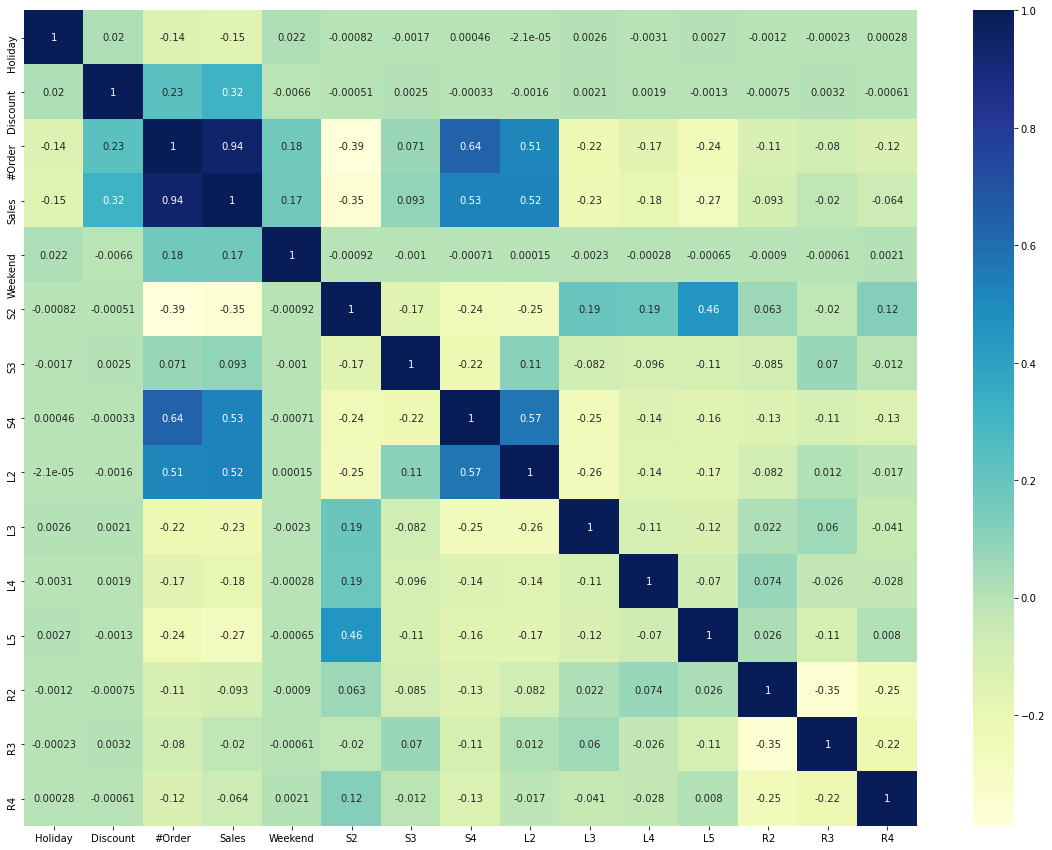

In [87]:
plt.figure(figsize=(20,15))
sns.heatmap(df_train.corr(),annot=True,cmap='YlGnBu')

### Split Data

In [138]:
y_train=df_train.pop('Sales')
Order=df_train.pop('#Order')   # Taking Order out of the dataframe as the test data does not have the order column.
# Also the Order and Sales columns are highly correlated
X_train=df_train

In [139]:
X_train.columns

Index(['Holiday', 'Discount', 'Weekend', 'S2', 'S3', 'S4', 'L2', 'L3', 'L4',
       'L5', 'R2', 'R3', 'R4'],
      dtype='object')

### Preparing model from backward approach

In [140]:
X_train_sm=sm.add_constant(X_train)

lr=sm.OLS(y_train,X_train_sm)
lr_model=lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 1.395e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:21:27   Log-Likelihood:            -1.3002e+05
No. Observations:              131838   AIC:                         2.601e+05
Df Residuals:                  131824   BIC:                         2.602e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5278      0.005   -104.818      0.000      -0.538      -0.518
Holiday       -0.4848      0.005    -91.595      0.000      -0.495      -0.474
Discount       0.6554      0.004    182.313      0.000       0.648       0.662
Weekend        0.3932      0.004     99.219      0.000       0.385       0.401
S2            -0.2618      0.006    -41.975      0.000      -0.274      -0.250
S3             0.2593      0.006     43.391      0.000       0.248       0.271
S4             0.7361      0.006    120.976      0.000       0.724       0.748
L2             0.5700      0.005    106.967      0.000       0.560       0.580
L3            -0.2430      0.006    -43.312      0.000      -0.254      -0.232
L4            -0.4210      0.008    -49.924      0.000      -0.438      -0.404
L5            -0.5491      0.009    -64.503      0.000      -0.566      -0.532
R2            -0.0346      0.005     -7.174      0.000      -0.044      -0.025
R3            -0.0507      0.005     -9.940      0.000      -0.061      -0.041
R4            -0.0569      0.006     -9.208      0.000      -0.069      -0.045
==============================================================================
Omnibus:                    42730.673   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           341425.318
Skew:                           1.340   Prob(JB):                         0.00
Kurtosis:                      10.414   Cond. No.                         8.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,L2,2.29
5,S4,2.13
3,S2,1.88
1,Discount,1.63
9,L5,1.51
10,R2,1.42
11,R3,1.37
7,L3,1.36
2,Weekend,1.33
4,S3,1.26


### Forward Approach

In [103]:
def prepare_model(X_train):
    X_train_sm=sm.add_constant(X_train)
    lr=sm.OLS(y_train,X_train_sm)
    lr_model=lr.fit()
    
    return lr_model

In [108]:
def cal_vif(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [104]:
lm1= prepare_model(X_train[['S4']])
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                 5.073e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:01:18   Log-Likelihood:             1.7669e+05
No. Observations:              131838   AIC:                        -3.534e+05
Df Residuals:                  131836   BIC:                        -3.533e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1507      0.000    751.181      0.000       0.150       0.151
S4             0.0915      0.000    225.238      0.000       0.091       0.092
==============================================================================
Omnibus:                    26262.070   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97785.765
Skew:                           0.969   Prob(JB):                         0.00
Kurtosis:                       6.747   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
lm2= prepare_model(X_train[['S4','L2']])
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                 3.580e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:01:42   Log-Likelihood:             1.8382e+05
No. Observations:              131838   AIC:                        -3.676e+05
Df Residuals:                  131835   BIC:                        -3.676e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1442      0.000    730.467      0.000       0.144       0.145
S4             0.0588      0.000    125.534      0.000       0.058       0.060
L2             0.0565      0.000    122.761      0.000       0.056       0.057
==============================================================================
Omnibus:                    24373.620   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101643.800
Skew:                           0.866   Prob(JB):                         0.00
Kurtosis:                       6.938   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
lm3= prepare_model(X_train[['S4','L2','Discount']])
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 3.674e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:02:44   Log-Likelihood:             1.9528e+05
No. Observations:              131838   AIC:                        -3.905e+05
Df Residuals:                  131834   BIC:                        -3.905e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1226      0.000    541.211      0.000       0.122       0.123
S4             0.0587      0.000    136.822      0.000       0.058       0.060
L2             0.0566      0.000    134.177      0.000       0.056       0.057
Discount       0.0482      0.000    158.207      0.000       0.048       0.049
==============================================================================
Omnibus:                    28444.753   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162500.481
Skew:                           0.921   Prob(JB):                         0.00
Kurtosis:                       8.118   Cond. No.                         4.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
cal_vif(X_train[['S4','L2','Discount']])

,Features,VIF
1,L2,1.90
0,S4,1.89
2,Discount,1.15


In [112]:
lm4= prepare_model(X_train[['S4','L2','Discount','Weekend']])
lm4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                 3.112e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:06:39   Log-Likelihood:             1.9905e+05
No. Observations:              131838   AIC:                        -3.981e+05
Df Residuals:                  131833   BIC:                        -3.980e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1144      0.000    477.955      0.000       0.114       0.115
S4             0.0587      0.000    140.875      0.000       0.058       0.060
L2             0.0566      0.000    138.008      0.000       0.056       0.057
Discount       0.0484      0.000    163.376      0.000       0.048       0.049
Weekend        0.0288      0.000     88.078      0.000       0.028       0.029
==============================================================================
Omnibus:                    27090.682   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           155968.530
Skew:                           0.869   Prob(JB):                         0.00
Kurtosis:                       8.037   Cond. No.                         4.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
cal_vif(X_train[['S4','L2','Discount','Weekend']])

,Features,VIF
1,L2,1.91
0,S4,1.90
2,Discount,1.25
3,Weekend,1.18


In [116]:
lm5= prepare_model(X_train[['S4','L2','Discount','Weekend','S2']])
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                 2.896e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:08:11   Log-Likelihood:             2.0408e+05
No. Observations:              131838   AIC:                        -4.082e+05
Df Residuals:                  131832   BIC:                        -4.081e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1236      0.000    499.723      0.000       0.123       0.124
S4             0.0536      0.000    132.415      0.000       0.053       0.054
L2             0.0508      0.000    127.440      0.000       0.050       0.052
Discount       0.0484      0.000    169.647      0.000       0.048       0.049
Weekend        0.0287      0.000     91.400      0.000       0.028       0.029
S2            -0.0418      0.000   -102.298      0.000      -0.043      -0.041
==============================================================================
Omnibus:                    31093.082   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           222779.035
Skew:                           0.949   Prob(JB):                         0.00
Kurtosis:                       9.079   Cond. No.                         4.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
lm5= prepare_model(X_train[['S4','L2','Discount','Weekend','S2','L5']])
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                 2.489e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:08:55   Log-Likelihood:             2.0516e+05
No. Observations:              131838   AIC:                        -4.103e+05
Df Residuals:                  131831   BIC:                        -4.102e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1246      0.000    505.969      0.000       0.124       0.125
S4             0.0530      0.000    132.031      0.000       0.052       0.054
L2             0.0502      0.000    126.814      0.000       0.049       0.051
Discount       0.0483      0.000    170.978      0.000       0.048       0.049
Weekend        0.0287      0.000     92.135      0.000       0.028       0.029
S2            -0.0329      0.000    -73.275      0.000      -0.034      -0.032
L5            -0.0282      0.001    -46.610      0.000      -0.029      -0.027
==============================================================================
Omnibus:                    32059.253   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           240749.163
Skew:                           0.970   Prob(JB):                         0.00
Kurtosis:                       9.329   Cond. No.                         5.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
lm6= prepare_model(X_train[['S4','L2','Discount','Weekend','S2','L5','L4']])
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                 2.188e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:12:01   Log-Likelihood:             2.0605e+05
No. Observations:              131838   AIC:                        -4.121e+05
Df Residuals:                  131830   BIC:                        -4.120e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1264      0.000    509.304      0.000       0.126       0.127
S4             0.0520      0.000    130.220      0.000       0.051       0.053
L2             0.0491      0.000    124.588      0.000       0.048       0.050
Discount       0.0484      0.000    172.202      0.000       0.048       0.049
Weekend        0.0287      0.000     92.747      0.000       0.028       0.029
S2            -0.0287      0.000    -62.868      0.000      -0.030      -0.028
L5            -0.0330      0.001    -53.992      0.000      -0.034      -0.032
L4            -0.0265      0.001    -42.261      0.000      -0.028      -0.025
==============================================================================
Omnibus:                    32698.321   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           255944.094
Skew:                           0.981   Prob(JB):                         0.00
Kurtosis:                       9.538   Cond. No.                         6.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
lm6= prepare_model(X_train[['S4','L2','Discount','Weekend','S2','L5','L4','L3','Holiday']])
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                 1.958e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:14:25   Log-Likelihood:             2.1117e+05
No. Observations:              131838   AIC:                        -4.223e+05
Df Residuals:                  131828   BIC:                        -4.222e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1355      0.000    515.945      0.000       0.135       0.136
S4             0.0493      0.000    127.072      0.000       0.049       0.050
L2             0.0460      0.000    119.931      0.000       0.045       0.047
Discount       0.0489      0.000    180.912      0.000       0.048       0.049
Weekend        0.0293      0.000     98.297      0.000       0.029       0.030
S2            -0.0225      0.000    -49.136      0.000      -0.023      -0.022
L5            -0.0423      0.001    -68.218      0.000      -0.043      -0.041
L4            -0.0341      0.001    -54.788      0.000      -0.035      -0.033
L3            -0.0200      0.000    -48.471      0.000      -0.021      -0.019
Holiday       -0.0362      0.000    -90.895      0.000      -0.037      -0.035
==============================================================================
Omnibus:                    41914.815   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           320472.372
Skew:                           1.323   Prob(JB):                         0.00
Kurtosis:                      10.165   Cond. No.                         7.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
lm6= prepare_model(X_train[['S4','L2','Discount','Weekend','S2','L5','L4','Holiday']])
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                 2.135e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:17:40   Log-Likelihood:             2.1000e+05
No. Observations:              131838   AIC:                        -4.200e+05
Df Residuals:                  131829   BIC:                        -4.199e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1307      0.000    532.300      0.000       0.130       0.131
S4             0.0520      0.000    134.224      0.000       0.051       0.053
L2             0.0490      0.000    128.338      0.000       0.048       0.050
Discount       0.0489      0.000    179.222      0.000       0.048       0.049
Weekend        0.0293      0.000     97.568      0.000       0.029       0.030
S2            -0.0288      0.000    -64.927      0.000      -0.030      -0.028
L5            -0.0329      0.001    -55.361      0.000      -0.034      -0.032
L4            -0.0266      0.001    -43.765      0.000      -0.028      -0.025
Holiday       -0.0362      0.000    -90.264      0.000      -0.037      -0.035
==============================================================================
Omnibus:                    40710.600   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           295371.323
Skew:                           1.295   Prob(JB):                         0.00
Kurtosis:                       9.860   Cond. No.                         6.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
lm6= prepare_model(X_train[['S4','L2','Discount','Weekend','S2','L5','Holiday']])
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                 2.378e+04
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:19:39   Log-Likelihood:             2.0905e+05
No. Observations:              131838   AIC:                        -4.181e+05
Df Residuals:                  131830   BIC:                        -4.180e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1290      0.000    528.499      0.000       0.128       0.129
S4             0.0530      0.000    136.037      0.000       0.052       0.054
L2             0.0501      0.000    130.583      0.000       0.049       0.051
Discount       0.0488      0.000    177.860      0.000       0.048       0.049
Weekend        0.0293      0.000     96.874      0.000       0.029       0.030
S2            -0.0330      0.000    -75.665      0.000      -0.034      -0.032
L5            -0.0280      0.001    -47.688      0.000      -0.029      -0.027
Holiday       -0.0362      0.000    -89.511      0.000      -0.037      -0.035
==============================================================================
Omnibus:                    39823.481   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           277342.154
Skew:                           1.275   Prob(JB):                         0.00
Kurtosis:                       9.632   Cond. No.                         5.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using RFE

In [121]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 7)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [122]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Holiday', True, 1),
 ('Discount', True, 1),
 ('Weekend', True, 1),
 ('S2', True, 1),
 ('S3', False, 3),
 ('S4', True, 1),
 ('L2', True, 1),
 ('L3', False, 4),
 ('L4', False, 2),
 ('L5', True, 1),
 ('R2', False, 7),
 ('R3', False, 6),
 ('R4', False, 5)]

In [141]:
y_train_pred=lr_model.predict()


<AxesSubplot:xlabel='Sales', ylabel='Density'>

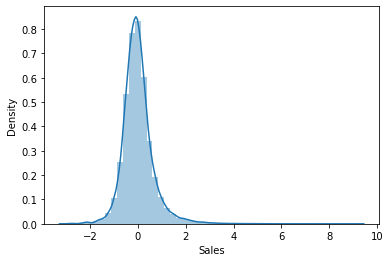

In [142]:
res=y_train-y_train_pred
sns.distplot(res)

In [143]:
r2_score(y_train,y_train_pred)

0.5791404361629007

In [144]:
np.sqrt(mean_squared_error(y_train, y_train_pred))

0.6487368987787726

## Evaluating the model

In [146]:
var_list=['#Order','Sales']
df_test[var_list]=scaler.transform(df_test[var_list])

In [147]:
y_test=df_test.pop('Sales')
Order=df_test.pop('#Order')   # Taking Order out of the dataframe as the test data does not have the order column.
# Also the Order and Sales columns are highly correlated
X_test=df_test

In [148]:
X_test_sm=sm.add_constant(X_test)
X_test_sm.head()

,const,Holiday,Discount,Weekend,S2,S3,S4,L2,L3,L4,L5,R2,R3,R4
60213,1.0,0,1,0,0,1,0,0,0,0,0,0,1,0
167058,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0
120401,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0
151218,1.0,1,0,0,1,0,0,0,0,0,0,1,0,0
45385,1.0,0,1,1,1,0,0,0,1,0,0,0,0,1


In [149]:
y_test_pred=lr_model.predict(X_test_sm)

In [150]:
r2_score(y_test,y_test_pred)

0.5844226756313018

In [151]:
np.sqrt(mean_squared_error(y_test, y_test_pred))

0.6478579930671123

In [153]:
lr_model.params

const      -0.527835
Holiday    -0.484788
Discount    0.655355
Weekend     0.393154
S2         -0.261812
S3          0.259316
S4          0.736123
L2          0.569985
L3         -0.243037
L4         -0.421005
L5         -0.549097
R2         -0.034585
R3         -0.050692
R4         -0.056869
dtype: float64

Text(0.5, 0.98, 'Actual and Predicted')

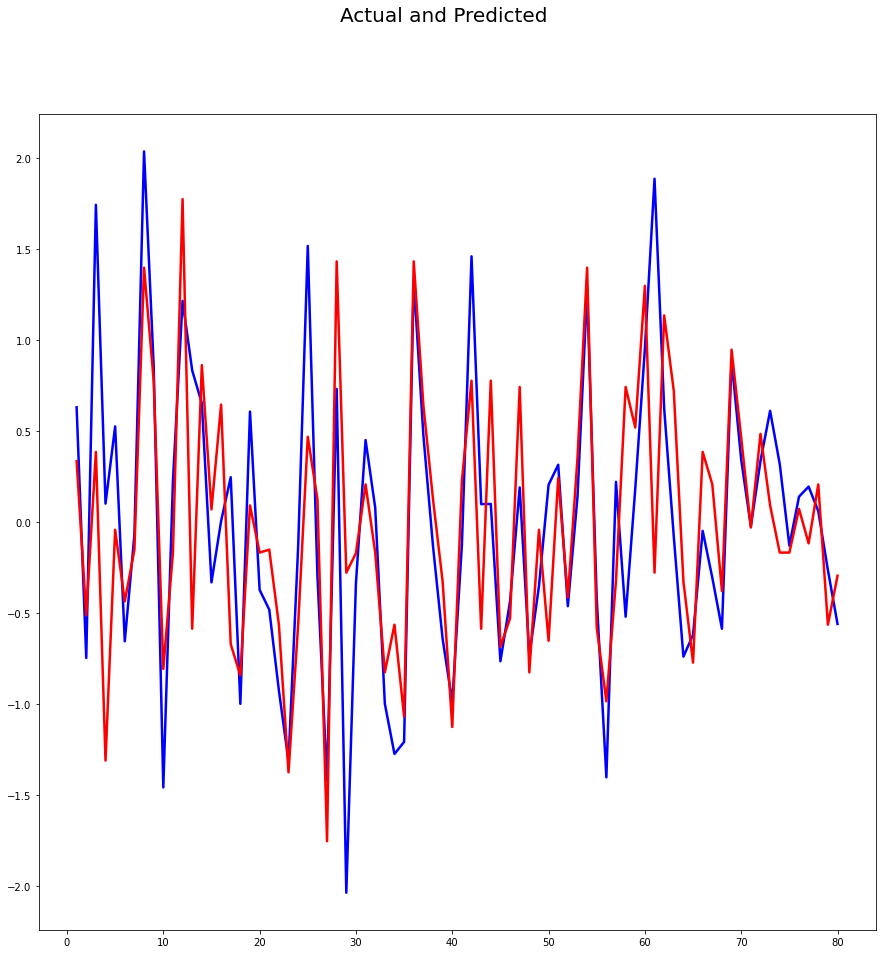

In [172]:
c = [i for i in range(1,81,1)]
fig = plt.figure(figsize=(15,15))
plt.plot(c,y_test[:80], color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_test_pred[:80], color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 